In [1]:
 #pip install tensorflow_datasets

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I wanted to love this movie. How could I not love it? Cary Grant, Jayne Mansfield, Stanley Donen; all icons in their own way. However, the train wreck that was Suzy Parker ruined the entire experience for me. Her acting was so appalling that I sat there with my jaw hanging open, not believing my eyes or ears. I could barely make it through one viewing, THAT'S how hideous she is in this.<br /><br />Cary? Gorgeous and in fine dramatic form. Jayne? Adorable, endearing, and obviously having a ball. The supporting cast does alright, and the city of San Francisco is captured in all its stunning, retro elegance.<br /><br />Then you see Suzy Parker attempting to speak her lines with a woodenness, a deadness, a cluelessness that simply defies belief. Who told this creature she could ACT?? Oy VEY, people."
 b'There\'s a certain allure I\'ve always found in discovering the great (semi-) unknown film. These discoveries have nearly always been dramatic films - in my experience, unknown s

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 453,   6, ...,   0,   0,   0],
       [213,   4, 772, ...,   0,   0,   0],
       [842,   1,   7, ...,   0,   0,   0]], dtype=int64)

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I wanted to love this movie. How could I not love it? Cary Grant, Jayne Mansfield, Stanley Donen; all icons in their own way. However, the train wreck that was Suzy Parker ruined the entire experience for me. Her acting was so appalling that I sat there with my jaw hanging open, not believing my eyes or ears. I could barely make it through one viewing, THAT'S how hideous she is in this.<br /><br />Cary? Gorgeous and in fine dramatic form. Jayne? Adorable, endearing, and obviously having a ball. The supporting cast does alright, and the city of San Francisco is captured in all its stunning, retro elegance.<br /><br />Then you see Suzy Parker attempting to speak her lines with a woodenness, a deadness, a cluelessness that simply defies belief. Who told this creature she could ACT?? Oy VEY, people."
Round-trip:  i wanted to love this movie how could i not love it [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] all [UNK] in their own way however the [UNK] [UNK] that was [UNK] [UNK] [UNK] 

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.0015257]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 187ms/step
[0.0015257]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=30)

391/391 [==============================] - 1029s 3s/step - loss: 0.6299 - accuracy: 0.5790 - val_loss: 0.4547 - val_accuracy: 0.7995


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 140s 359ms/step - loss: 0.4528 - accuracy: 0.7966
Test Loss: 0.4528031349182129
Test Accuracy: 0.7966399788856506


(0.0, 0.6386515289545059)

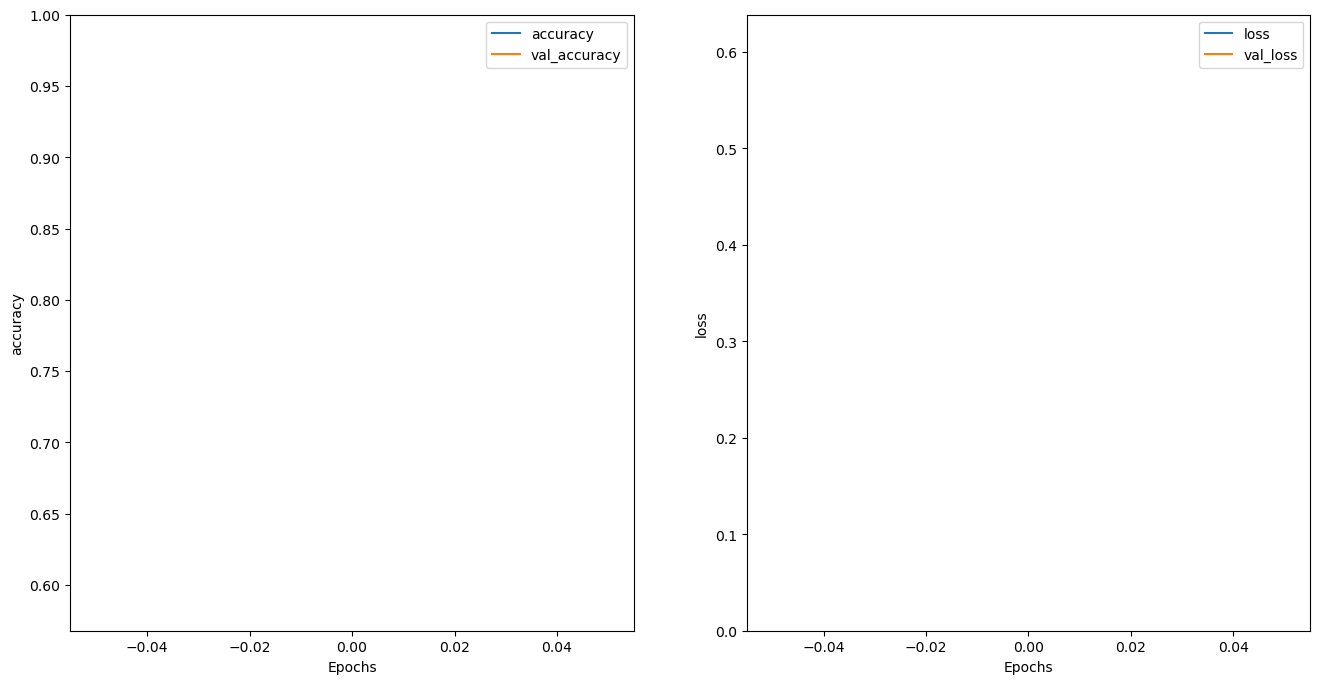

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [22]:
predictions

array([[-0.03693609]], dtype=float32)

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
 79/391 [=====>........................] - ETA: 21:11 - loss: 0.6927 - accuracy: 0.5008

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')